In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,Dense,LSTM,Dropout,Bidirectional,BatchNormalization
from tensorflow.keras.optimizers import Adam
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [2]:
data=pd.read_csv("emotion_dataset.csv")
data.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [3]:
def preprocess_text(text):
    text=text.lower()
    text=re.sub(r'http\S+','',text)
    text=re.sub(r'@\w+','',text)
    text=re.sub(r'#\w','',text)
    text=re.sub(r'[^a-z\s]','',text)
    text=re.sub(r'\s+',' ',text).strip()
    return text
data["text"]=data["text"].astype(str).apply(preprocess_text)

In [4]:
label_encoder=LabelEncoder()
data["label"]=label_encoder.fit_transform(data["label"])

In [5]:
data.head()

,text,label
0,i didnt feel humiliated,3
1,i can go from feeling so hopeless to so damned...,3
2,im grabbing a minute to post i feel greedy wrong,0
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,0


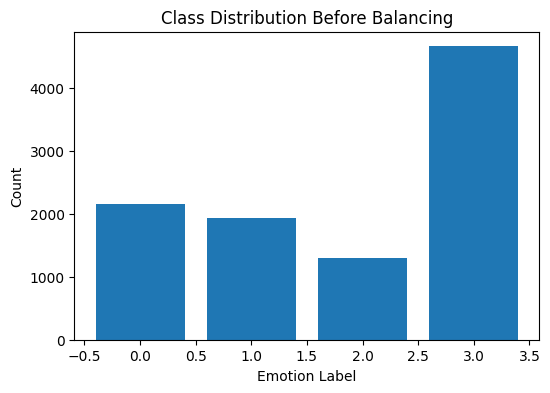

In [6]:
plt.figure(figsize=(6,4))
plt.bar(Counter(data['label']).keys(),Counter(data['label']).values())
plt.title("Class Distribution Before Balancing")
plt.xlabel("Emotion Label")
plt.ylabel("Count")
plt.show()

In [7]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(data["text"])
vocal_size=len(tokenizer.word_index)+1
max_length=100

X=tokenizer.texts_to_sequences(data["text"])
X=pad_sequences(X,maxlen=max_length,padding='post')
y=data["label"].values

In [8]:
ros=RandomOverSampler(random_state=42)
X_resampled,y_resampled=ros.fit_resample(X,y)

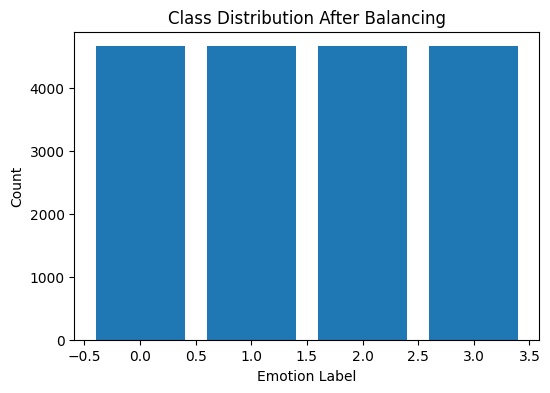

In [9]:
plt.figure(figsize=(6,4))
plt.bar(Counter(y_resampled).keys(),Counter(y_resampled).values())
plt.title("Class Distribution After Balancing")
plt.xlabel("Emotion Label")
plt.ylabel("Count")
plt.show()

In [10]:
X_train,X_test,y_train,y_test=train_test_split(X_resampled,y_resampled,test_size=0.2,random_state=42)

In [11]:
model=Sequential([
    Embedding(input_dim=vocal_size,output_dim=200,input_length=max_length),
    Bidirectional(LSTM(128,return_sequences=True)),
    BatchNormalization(),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32,activation='relu'),
    BatchNormalization(),
    Dense(len(np.unique(y_resampled)),activation='softmax')
])

In [12]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history=model.fit(X_train,y_train,epochs=10,batch_size=32,validation_split=0.1,verbose=1)

Epoch 1/10
420/420 [==============================] - 187s 413ms/step - loss: 1.0067 - accuracy: 0.5713 - val_loss: 0.3901 - val_accuracy: 0.8855
Epoch 2/10
420/420 [==============================] - 173s 412ms/step - loss: 0.1842 - accuracy: 0.9466 - val_loss: 0.2398 - val_accuracy: 0.9337
Epoch 3/10
420/420 [==============================] - 169s 403ms/step - loss: 0.0873 - accuracy: 0.9760 - val_loss: 0.1869 - val_accuracy: 0.9444
Epoch 4/10
420/420 [==============================] - 169s 401ms/step - loss: 0.0633 - accuracy: 0.9814 - val_loss: 0.1344 - val_accuracy: 0.9652
Epoch 5/10
420/420 [==============================] - 169s 403ms/step - loss: 0.0514 - accuracy: 0.9859 - val_loss: 0.1894 - val_accuracy: 0.9605
Epoch 6/10
420/420 [==============================] - 168s 399ms/step - loss: 0.0437 - accuracy: 0.9886 - val_loss: 0.1281 - val_accuracy: 0.9705
Epoch 7/10
420/420 [==============================] - 176s 418ms/step - loss: 0.0382 - accuracy: 0.9891 - val_loss: 0.1188 -

In [13]:
test_loss,test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(f'Test Acuuracy:{test_accuracy:.4f}')

Test Acuuracy:0.9751


In [15]:
import joblib 
model.save("emotion_model.h5")
joblib.dump(tokenizer,"tokenizer.jb")
joblib.dump(label_encoder,"label_encoder.jb")

c:\Users\Lenovo\EMOTION_DETECTION\venv310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


['label_encoder.jb']